# LatamXIX Overveiw

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder

## Surface Forms

In [2]:
with open("./data/surfaceForms.json", encoding='utf-8') as f:
    surfaceForms = json.load(f)
with open("./data/surfaceFormsNonAccents.json", encoding='utf-8') as f:
    surfaceFormsNonAccents = json.load(f)

i = 0
for k,v in surfaceFormsNonAccents.items():
    print(f"The word '{k}' can be find as '{list(v.keys())[0]}'")
    if (i := i+1) > 10: break

The word 'y' can be find as 'i'
The word 'suscripción' can be find as 'suscricion'
The word 'muy' can be find as 'mui'
The word 'hay' can be find as 'hai'
The word 'suscripciones' can be find as 'suscriciones'
The word 'hoy' can be find as 'hoi'
The word 'general' can be find as 'jeneral'
The word 'jefe' can be find as 'gefe'
The word 'suscriptores' can be find as 'suscritores'
The word 'septiembre' can be find as 'setiembre'
The word 'extranjero' can be find as 'extrangero'


In [3]:
print(f"Surface Forms: {len(surfaceForms)}")
print(f"Non-Accent Surface Forms: {len(surfaceFormsNonAccents)}")

Surface Forms: 37492
Non-Accent Surface Forms: 7466


## Dataset

In [4]:
# read the parquet file
cleaneddf = pd.read_parquet("./data/cleaned-latam-xix.parquet")
df = pd.read_parquet("./data/corrected-latam-xix.parquet")
df.sample(10)

,newspaper_id,text_id,title,year,city,text
43086,PD1776,ElMosquito186502-page_3-0,El mosquito,1863-1887,"Buenos Aires, Argentina","Mata blanquito, No come na Poque no quele Tlab..."
36235,PD1695,558a33f77d1ed64f169e4428-page_0-0,Hijo de Ahuizote,1897-1899,Ciudad de México,"Carteras, jeles de Sucursales y demás empleado..."
32703,PD1695,558a33ec7d1ed64f169d73f2-page_0-1,Hijo de Ahuizote,1897-1899,Ciudad de México,ellas juraba en falso. Uma cedula de los Reyes...
60406,PD751,9-page_14-2,El zancudo,1890-1891,Santafé de Bogotá,El suero. PARODIA .. Un inglés dijo admirado d...
13608,PD1366,558a36237d1ed64f16c34557-page_0-1,El padre cobos,1869-1880,Ciudad de México,-Han invadido 4 infinidad de pueblos come Texc...
57847,PD697,p17054coll26_355-page_4-1,Papel Periodico ilustrado,1881-1888,Cali,"NUMERO 49 - ANO III. es reconocido O' HIGGINS,..."
2120,PD1104,elperuilustrado1888lima-page_411-0,Peru Ilustrado,1887-1891,"Lima, Perú","un cañonazo, hace llover algo, que Zola apelli..."
63609,PF730,20230917_104230-page_0-0,Mefistofeles,1897-1905,Bogotá,"inerte y recto, que desempeño en serio sus eli..."
19423,PD1475,558a340d7d1ed64f169fe60a-page_0-2,La carabina de ambrosio,1875,Ciudad de México,Hasta los gansos del dhuizole pueden graz- | l...
49580,PD1985,BNA_S001184221_18870116N022-page_1-2,Don Quijote,1884-1903,"Buenos Aires, Argentina","| Limpoñado, segun creo en que nos pare algo g..."


See the corections made to a random text in the dataset. Take into account that surface form were extracted BUT NOT replaced in the dataset.

In [5]:
rd_idx = random.randint(0, len(cleaneddf) - 1)

print(cleaneddf.loc[rd_idx, "text"])
print(df.loc[rd_idx, "text"])

REDACCION ADMINISTRACION, 2. DE VANEGAS Nº 6. D. BERASTIAN Y QUERIDITOR ,D. Sobastian. - Que tal? Queridito 1. - Asi, usi, ay vd. no. for Presidentu? D. Sebastian ,- Un pooo dosvolado: hasta las cuatro do la mañana estuvo con mi ministro de guerra acordando un plan de campaña. Quoridito" 2. " -¿ Una campaña? ¡ Y para qué? ¿ Pues no acabú ya la royoluoiont D. Sebastian; - Que ha do acabar !. Si apenas ahora comionan. Temblor entro los quoriditos. D. Sebastian ,- Y'vdos, que andan en la calle mo dirin; cosmo anda la 2 opinion pitblica! Quoridito 3º-Contamos con olla. D. Sebastian .- Estamos on confinner modo tan vago, tan alsisonante y tan auf es que no hay que decir mouticas, Queridito 1.º-La verdad 'os que la opinion publica grita forozmonte, D. Sebastian ,-¡ Poro paga? Queridito 3.º-Muy flojamonto. D. Sebastian .- Que grito con tal que pague
REDACCION ADMINISTRACION, 2. DE VANEGAS Nº 6. D. BERASTIAN Y QUERIDITOR ,D. Sobastian. - Que tal? Queridito 1. - Asi, usi, ay vd. no. for Preside

### Information

First, train a new tokenizer on the final, corrected dataset.

In [6]:
VOCAB_SIZE = 52000
TRAINING_BATCH_SIZE = 1000
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"

pretrained_tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

training_corpus = (
    df.loc[i:i+TRAINING_BATCH_SIZE, "text"].astype(str) 
    for i in range(0, len(df), TRAINING_BATCH_SIZE)
)

tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus, VOCAB_SIZE)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
example = df.loc[5, "text"]
print("BEFORE:", pretrained_tokenizer.tokenize(example)[:20])
print("AFTER:", tokenizer.tokenize(example)[:20])
tokenizer.save_pretrained("./data/tokenizer")

Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (781 > 512). Running this sequence through the model will result in indexing errors


BEFORE: ['46', '##1', ',', '60', 'Y', '[UNK]', 'de', 'arrepent', '##irse', 'de', 'tal', 'ase', '##r', '##cion', ',', 'I', 'se', 'les', 'bar', '##re']
AFTER: ['46', '##1', ',', '60', 'Y', 'debi', '##ć', 'de', 'arrepentirse', 'de', 'tal', 'aser', '##cion', ',', 'I', 'se', 'les', 'barre', 'una', 'perten']


('./data/tokenizer\\tokenizer_config.json',
 './data/tokenizer\\special_tokens_map.json',
 './data/tokenizer\\vocab.txt',
 './data/tokenizer\\added_tokens.json',
 './data/tokenizer\\tokenizer.json')

In [8]:
# find the number of tokens in the whole df

total_tokens = df['text'].apply(lambda x: len(tokenizer.tokenize(x))).sum()
total_words = df['text'].apply(lambda x: len(x.split())).sum()

print(f"LatamXIX dataset has:\n\ttokens: {total_tokens:,}\n\twords: {total_words:,}\n\ttexts: {len(df):,}")

LatamXIX dataset has:
	tokens: 28,677,139
	words: 22,002,110
	texts: 64,077


In [12]:
unique_count = df["newspaper_id"].nunique()
print(f"{unique_count} newspapers in the dataset")

197 newspapers in the dataset


In [9]:
df['year_low'] = df['year'].str.split('-').str[0]
df['year_low'] = df['year_low'].astype(int)
df['year_high'] = df['year'].apply(lambda x: x.split('-')[1] if len(x.split('-')) == 2 else x.split('-')[0])
df['year_high'] = df['year_high'].astype(int)

print(f"\nYears: {df['year_low'].min()} - {df['year_low'].max()}")


Years: 1806 - 1899


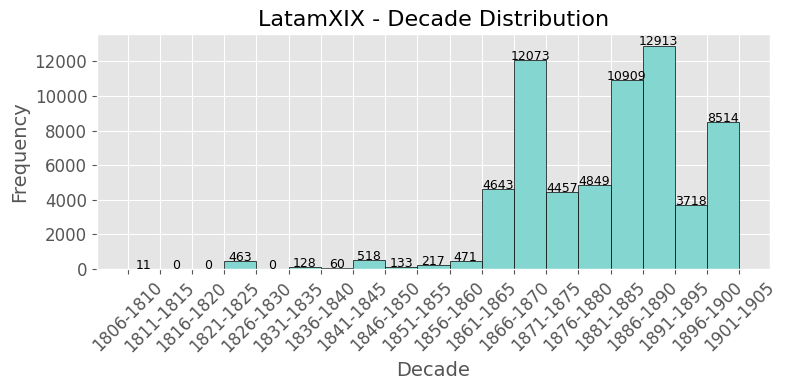

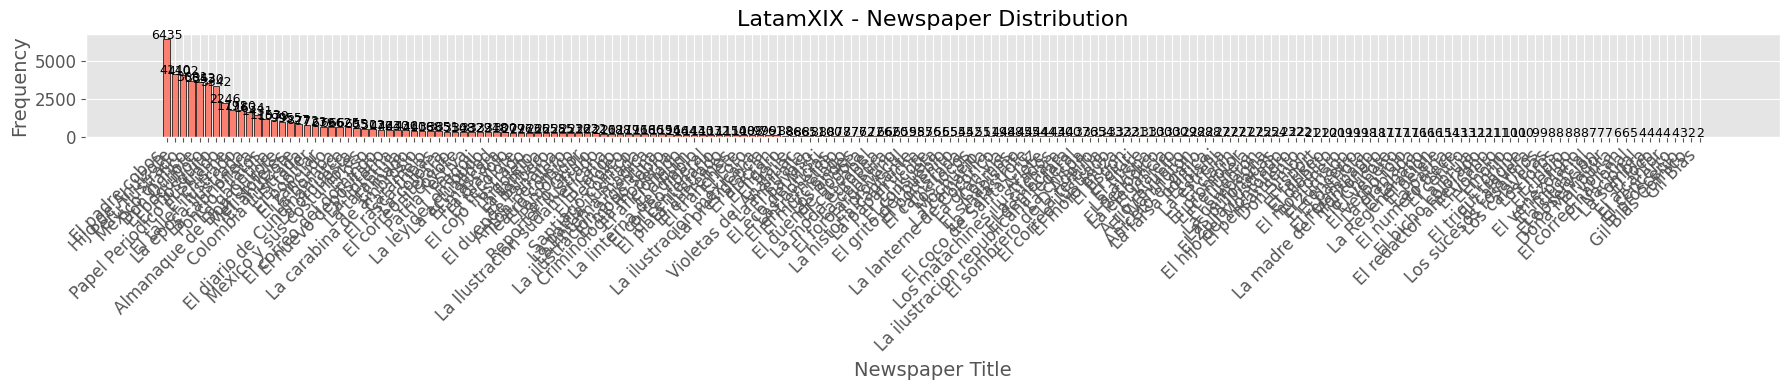

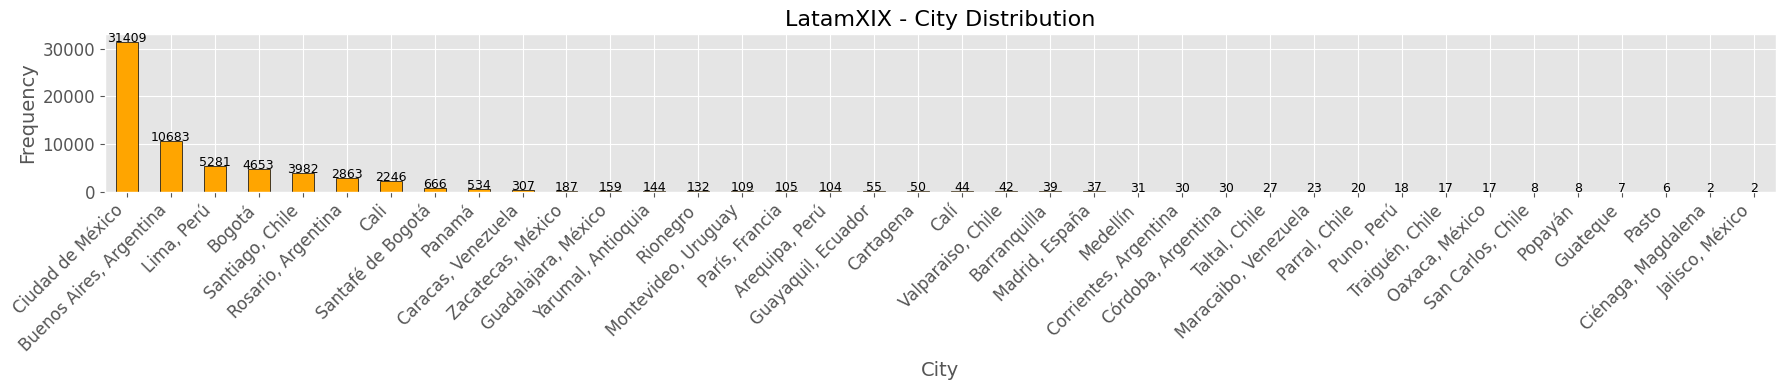

In [10]:
plt.style.use('ggplot')

# Histogram by Decade

min_year = df['year_low'].min()
max_year = df['year_low'].max()
bin_width = 5
num_bins = (max_year - min_year) // bin_width + 1
bins = np.linspace(min_year, min_year + (num_bins * bin_width), num_bins + 1)

plt.figure(figsize=(8, 4))
plt.hist(df['year_low'], bins=bins, edgecolor='black', align='mid', color='#84D6D0')
plt.title('LatamXIX - Decade Distribution', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=12)

plt.xticks(np.arange(min_year, max_year + bin_width, bin_width), [f'{int(year)}-{int(year+bin_width-1)}' for year in np.arange(min_year, max_year + bin_width, bin_width)], rotation=45, ha='center', fontsize=12)

for i, count in enumerate(np.histogram(df['year_low'], bins=bins)[0]):
    plt.text(bins[i]+2.5, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_years_histogram.png', dpi=300)
plt.show()

# Histogram by Newspaper Title

label_encoder = LabelEncoder()
df['title_label'] = label_encoder.fit_transform(df['title'])

title_counts = df['title_label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(18, 4))
plt.bar(range(len(title_counts)), title_counts.values, color='salmon', edgecolor='black')
plt.title('LatamXIX - Newspaper Distribution', fontsize=16)
plt.xlabel('Newspaper Title', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(len(title_counts)), label_encoder.inverse_transform(title_counts.index), rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(title_counts.values):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_titles_histogram.png', dpi=300)
plt.show()

# Histogram by City

plt.figure(figsize=(18, 4))
df['city'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title('LatamXIX - City Distribution', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(df['city'].value_counts()):
    plt.text(i, count + 2.5, str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('./imgs/latamxix_city_histogram.png', dpi=300)
plt.show()